In [43]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from IPython.display import clear_output

clear_output()

In [44]:
def read_kImage(path):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    return ct_scan

In [45]:
def extract_voxel_data(series_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( series_path )
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_3d = sitk.GetArrayFromImage(image)
    return image_3d

In [46]:
def normalize_image(image_3D):
    z,y,x = image_3D.shape
    new_image_3D = np.empty(shape = (z,y,x) )
    target_min = -1
    target_max = 1
    for i in range (z):
        max_value = np.max (image_3D[i])
        min_value = np.min (image_3D[i])
        new_image_3D[i] = (image_3D[i] - min_value)*(float(target_max - target_min)/(max_value - min_value)) + target_min
    return new_image_3D

In [47]:
def subvoxel (img_3d,ijk, window):
    ijk = ijk.split()
    x = int(ijk[0])
    y = int(ijk[1])
    z = int(ijk[2])
    if (z < 0):
        z = z*(-1)
    new_img3d = np.empty(shape = (3,img_3d.shape[1], img_3d.shape[2]))
    max_bandwith = img_3d.shape[0] - 1
    if ( z == max_bandwith ):
        new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
        new_img3d[1,:,:] = img_3d[z,:,:] #n
        new_img3d[2,:,:] = img_3d[z,:,:] #n
    else:
        if (z == 0):
            new_img3d[0,:,:] = img_3d[z,:,:] #0
            new_img3d[1,:,:] = img_3d[z,:,:] #0
            new_img3d[2,:,:] = img_3d[z+1,:,:] #1
        else:
            new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
            new_img3d[1,:,:] = img_3d[z,:,:] #n
            new_img3d[2,:,:] = img_3d[z+1,:,:] #n+1
    window = window//2
    new_img3d = new_img3d[:, y-window : y+window, x-window : x+window]
    return new_img3d

In [48]:
def generate_training_dataframes():
    basedir = "../1/train/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Train.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Train.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Train.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid"])
    #agregamos una columna para insertar la imagen
    #agregamos una columna para los parches
    #agregamos otra columna para la integridad de los datos
    #agregamos otra columna para las predicciones
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_images_table["InterestSequence"] = pd.Series(False, index= join_images_table.index)
    join_images_table["Predictions"] = pd.Series(0, index= join_images_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    join_kimages_table["Predictions"] = pd.Series(0, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [49]:
training_MRI_imgs_dataframe, training_ktrans_imgs_dataframe = generate_training_dataframes()


In [50]:
def isValid_data(img_3d, ijk):
    state = False
    k_string = ijk.split()[2]
    max_bandwith = img_3d.shape[0] -1
    possible_k = int (k_string)
    if (possible_k >= max_bandwith):
        possible_k = max_bandwith
        slice_index = possible_k
        state = True
        print("The ijk requested is [{}], there was an error since the shapes of the image is {}".format(ijk,str(img_3d.shape)))
    else:
        if possible_k >= 0:
            slice_index = possible_k
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
        else:
            state = False
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
    return state

In [51]:
def set_MRI_value(dataFrame,index,image3d,state,window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"MRI3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"MRIPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"MRIPatch3D"] = np.zeros(shape= (window,image3d.shape[0],image3d.shape[1]))
    

In [52]:
def set_kImg_value(dataFrame,index,image3d,state, window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"Kimg3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"KimgPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"KimgPatch3D"] = np.empty(shape= image3d.shape)
    

In [53]:
def fill_ktrans_images_dataframe_at_training(dataFrame, window):
    if window == None:
        window = 40
    for row in range(len(dataFrame)):
        path = "../1/train/ProstateXKtrains-train-fixed"
        patient_id = dataFrame.ProxID.iloc[row]
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        kimage_3d = normalize_image(kimage_3d)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state,window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [54]:
window = 40
fill_ktrans_images_dataframe_at_training(dataFrame = training_ktrans_imgs_dataframe , window =window)
#fill_ktrans_images_dataframe_at_testing(dataFrame = testing_ktrans_imgs_dataframe, window = window)
clear_output()
print ("All the Ktrans training images were read correctly")
print ("All the Ktrans testing images were read correctly")
training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe[ training_ktrans_imgs_dataframe.State == False]
training_ktrans_imgs_dataframe.reset_index(drop=True)
training_ktrans_imgs_dataframe.index = pd.RangeIndex(len(training_ktrans_imgs_dataframe))
display(training_ktrans_imgs_dataframe[["ProxID", "fid", "ijk", "ClinSig"]].iloc[35:60])

All the Ktrans training images were read correctly
All the Ktrans testing images were read correctly


,ProxID,fid,ijk,ClinSig
35,ProstateX-0025,1,67 88 -7,False
36,ProstateX-0025,1,75 79 7,False
37,ProstateX-0025,1,81 77 7,False
38,ProstateX-0025,1,67 88 -7,False
39,ProstateX-0025,1,75 79 7,False
40,ProstateX-0025,1,81 77 7,False
41,ProstateX-0025,2,57 89 -7,False
42,ProstateX-0025,2,71 79 7,False
43,ProstateX-0025,3,46 80 -7,False
44,ProstateX-0025,3,60 70 8,False


In [55]:
def fill_MRI_images_dataframe_at_training(dataFrame, window):
    for row in range (len(dataFrame)):
        print("===============================================================")
        patient_id = dataFrame.ProxID.iloc[row]
        series_name = dataFrame.DCMSerDescr.iloc[row]
        series_id = dataFrame.DCMSerNum.iloc[row]
        slice_ijk = dataFrame.ijk.iloc[row]
        sequence_name = dataFrame.Name.iloc[row]
        path = "../1/train/PROSTATEx/{}/".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        #sequence = [ sequence for sequence in sequences if sequence[0:len(str(series_id))] == str(series_id) ] [0]
        for sequence in sequences:
            sequence_id = sequence[0:len(str(series_id))]
            if (str(sequence_id) == str(series_id)):
                print ("The condition is true {} = {}".format(sequence_id,series_id))
                print ("The sequence selected is {}".format(sequence))
                print ("The requested sequence is {}".format(sequence_name))
                break
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state = isValid_data(ijk=slice_ijk, img_3d=image_3d)
        set_MRI_value(dataFrame,row,image_3d,state,40)
        print("Se ha cargado la imagen MRI3D y MRI3DPATCH #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d

In [56]:
fill_MRI_images_dataframe_at_training(dataFrame = training_MRI_imgs_dataframe, window = window)
clear_output()
print ("All the MRI training images were read correctly")
training_MRI_imgs_dataframe =training_MRI_imgs_dataframe[ training_MRI_imgs_dataframe.State == False]
training_MRI_imgs_dataframe.reset_index(drop=True)
training_MRI_imgs_dataframe.index = pd.RangeIndex(len(training_MRI_imgs_dataframe))
display(training_MRI_imgs_dataframe[["ProxID", "fid", "ijk", "ClinSig"]].iloc[35:60])


All the MRI training images were read correctly


,ProxID,fid,ijk,ClinSig
35,ProstateX-0002,2,45 70 9,False
36,ProstateX-0002,2,134 137 1,False
37,ProstateX-0002,2,153 151 0,False
38,ProstateX-0002,2,170 186 12,False
39,ProstateX-0002,2,178 169 8,False
40,ProstateX-0002,2,203 216 10,False
41,ProstateX-0002,2,68 72 8,False
42,ProstateX-0003,1,54 68 11,False
43,ProstateX-0003,1,54 68 11,False
44,ProstateX-0003,1,54 68 11,False


In [57]:
#find substrings
def return_MRI_serie_of_interest(serie_of_interest):
    for i in range (len( training_MRI_imgs_dataframe )):
        training_MRI_imgs_dataframe.at[i,"InterestSequence"] = False
        if (training_MRI_imgs_dataframe.DCMSerDescr.iloc[i].find(serie_of_interest) != -1):
            training_MRI_imgs_dataframe.at[i,"InterestSequence"] = True

    dataframe = training_MRI_imgs_dataframe[ training_MRI_imgs_dataframe.InterestSequence == True ]
    return dataframe

In [66]:
#DWI-ADC
serie_of_interest = "adc"
dyndist_adc_dataframe = return_MRI_serie_of_interest(serie_of_interest)
dyndist_adc_dataframe.reset_index(drop=True)
dyndist_adc_dataframe.index = pd.RangeIndex(len(dyndist_adc_dataframe))

#t2_tse_sag
serie_of_interest = "t2_tse_sag"
t2_tse_sag_dataframe = return_MRI_serie_of_interest(serie_of_interest)
t2_tse_sag_dataframe.reset_index(drop=True)
t2_tse_sag_dataframe.index = pd.RangeIndex(len(t2_tse_sag_dataframe))

#t2_tse_tra
serie_of_interest = "t2_tse_tra"
t2_tse_tra_dataframe = return_MRI_serie_of_interest(serie_of_interest)
t2_tse_tra_dataframe.reset_index(drop=True)
t2_tse_tra_dataframe.index = pd.RangeIndex(len(t2_tse_tra_dataframe))

In [70]:
#DWI-ADC
serie_of_interest = "adc"
dyndist_adc_dataframe = return_MRI_serie_of_interest(serie_of_interest)
dyndist_adc_dataframe.reset_index(drop=True)
dyndist_adc_dataframe.index = pd.RangeIndex(len(dyndist_adc_dataframe))

In [71]:
def setup_MRI_series_descriptions():
    for i in range (len(training_MRI_imgs_dataframe)):
        DCM_description = str.lower( training_MRI_imgs_dataframe.DCMSerDescr.iloc[i] )
        DCM_description = DCM_description.replace(" ","_")
        DCM_description = DCM_description.replace("-","_")
        training_MRI_imgs_dataframe.at[i,"DCMSerDescr"] = DCM_description
    print(training_MRI_imgs_dataframe.DCMSerDescr.unique())

setup_MRI_series_descriptions()

['ep2d_diff_tra_dyndist_adc' 'ep2d_diff_tra_dyndist'
 'ep2d_diff_tra_dyndistcalc_bval' 't2_tse_cor' 't2_tse_sag' 't2_tse_tra'
 'tfl_3d_pd_ref_tra_1.5x1.5_t3' 'ep2d_diff_tra_dyndist_mix_adc'
 'ep2d_diff_tra_dyndist_mix' 'ep2d_diff_tra_dyndist_mixcalc_bval'
 't2_localizer' 't2_loc_sag' 't2_tse_tra_exacte_copy_diffusie'
 't2_loc_tra' 'adc_s3_1' 'adc_s3_2'
 'ep2d_diff_tra2x2_noise0_fs_dyndist_adc'
 'ep2d_diff_tra2x2_noise0_fs_dyndist'
 'ep2d_diff_tra2x2_noise0_fs_dyndistcalc_bval'
 'ep2d_diff_tra2x2_noise0_nofs_dyndist_adc'
 'ep2d_diff_tra2x2_noise0_nofs_dyndist'
 'ep2d_diff_tra2x2_noise0_nofs_dyndistcalc_bval'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=10.2s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=100.5s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=101.7s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=103.0s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=104.2s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=105.5s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=106.8s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=10

In [73]:
dyndist_adc_dataframe[["ProxID","fid","State","ClinSig","DCMSerDescr"]]

,ProxID,fid,State,ClinSig,DCMSerDescr
0,ProstateX-0000,1,False,True,ep2d_diff_tra_dyndist_adc
1,ProstateX-0001,1,False,False,ep2d_diff_tra_dyndist_mix_adc
2,ProstateX-0002,1,False,True,ep2d_diff_tra_dyndist_adc
3,ProstateX-0002,2,False,False,ep2d_diff_tra_dyndist_adc
4,ProstateX-0003,1,False,False,ep2d_diff_tra_dyndist_adc
5,ProstateX-0003,2,False,False,ep2d_diff_tra_dyndist_adc
6,ProstateX-0004,1,False,False,ep2d_diff_tra_dyndist_mix_adc
7,ProstateX-0005,0,False,True,ep2d_diff_tra_dyndist_mix_adc
8,ProstateX-0005,1,False,True,ep2d_diff_tra_dyndist_mix_adc
9,ProstateX-0005,1,False,True,ep2d_diff_tra_dyndist_mix_adc


In [74]:
t2_tse_sag_dataframe[["ProxID","fid","State","ClinSig","DCMSerDescr"]]

,ProxID,fid,State,ClinSig,DCMSerDescr
0,ProstateX-0000,1,False,True,t2_tse_sag
1,ProstateX-0001,1,False,False,t2_tse_sag
2,ProstateX-0002,1,False,True,t2_tse_sag
3,ProstateX-0002,2,False,False,t2_tse_sag
4,ProstateX-0003,1,False,False,t2_tse_sag
5,ProstateX-0003,2,False,False,t2_tse_sag
6,ProstateX-0004,1,False,False,t2_tse_sag
7,ProstateX-0005,0,False,True,t2_tse_sag
8,ProstateX-0005,1,False,True,t2_tse_sag
9,ProstateX-0005,1,False,True,t2_tse_sag


In [75]:
t2_tse_tra_dataframe[["ProxID","fid","State","ClinSig","DCMSerDescr"]]

,ProxID,fid,State,ClinSig,DCMSerDescr
0,ProstateX-0000,1,False,True,t2_tse_tra
1,ProstateX-0001,1,False,False,t2_tse_tra
2,ProstateX-0001,1,False,False,t2_tse_tra
3,ProstateX-0002,1,False,True,t2_tse_tra
4,ProstateX-0002,2,False,False,t2_tse_tra
5,ProstateX-0003,1,False,False,t2_tse_tra
6,ProstateX-0003,2,False,False,t2_tse_tra
7,ProstateX-0004,1,False,False,t2_tse_tra
8,ProstateX-0005,0,False,True,t2_tse_tra
9,ProstateX-0005,1,False,True,t2_tse_tra


In [76]:
ktrans_dataframe = training_ktrans_imgs_dataframe
ktrans_dataframe[["ProxID","fid","State","ClinSig"]]

,ProxID,fid,State,ClinSig
0,ProstateX-0000,1,False,True
1,ProstateX-0001,1,False,False
2,ProstateX-0002,1,False,True
3,ProstateX-0002,2,False,False
4,ProstateX-0003,1,False,False
5,ProstateX-0003,2,False,False
6,ProstateX-0004,1,False,False
7,ProstateX-0005,0,False,True
8,ProstateX-0005,1,False,True
9,ProstateX-0005,1,False,True


In [77]:

def get_dataframe_given_zone(zone, dataFrame):
    dataFrame = dataFrame[dataFrame.zone == zone]
    return dataFrame

In [78]:
def get_data_labels (dataFrame,sequence):
    indexes = dataFrame.index
    if( sequence.lower() == "ktrans"):
        data = dataFrame.KimgPatch3D
    else:
        data = dataFrame.MRIPatch3D
    labels = dataFrame.ClinSig
    z,y,x = [3,40,40]
    all_data = np.empty(shape= (len(data), z*y*x ) )
    all_labels = np.zeros(shape= (len(data) ) )
    i = 0
    for index in indexes:
        all_data[i,:] = data[index].reshape((1,x*y*z))
        label = labels [index]
        all_labels[i] = label
        i = i + 1
    return all_data, all_labels

In [79]:
def apply_Kfold_cross_validation(data, labels, classifier, kfolds):
    from sklearn.model_selection import cross_val_score
    #data, labels = get_data_labels(dataframe)

    scores = cross_val_score(classifier, data, labels, cv= kfolds)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores, scores.mean()*100, scores.std()*100

In [80]:
def plot_ROC_curve(classifier, data_test, labels_test):
    from sklearn import metrics
    probs = classifier.predict_proba(data_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(labels_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0,  1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [27]:
del training_MRI_imgs_dataframe
del training_ktrans_imgs_dataframe

## LeNet Model

In the following cells we are going to introduce the LeNet Deep learning arquitecture, we are going to make some experiments in order to study the behavior of this model with our data.

In [153]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D,AveragePooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Dropout
from keras.utils import to_categorical
import tensorflow as tf
 

In [154]:
from tensorflow.python.keras.optimizers import Adam
optimizer = Adam(lr=1e-3)

In [155]:
import numpy as np
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'

from keras import backend as k

# Running the below code every time
np.random.seed(27)
rn.seed(27)
tf.set_random_seed(27)

sess = tf.Session(graph=tf.get_default_graph())
k.set_session(sess)

In [156]:
img_shape_full = (window,window,3)
img_size_flat = 3*window*window
num_classes = 2
print(img_shape_full)
print(img_size_flat)
def leNet():
    model = Sequential()
    model.add(InputLayer(input_shape=(img_size_flat,)))
    model.add(Reshape(img_shape_full))
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=2, strides=2))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D( pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.save_weights('model.h5')
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = leNet()
model.summary()

(40, 40, 3)
4800
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 38, 38, 6)         168       
_________________________________________________________________
average_pooling2d_26 (Averag (None, 19, 19, 6)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 17, 17, 16)        880       
_________________________________________________________________
average_pooling2d_27 (Averag (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 120)               1230

In [157]:
def get_all_data_labels_Ktrans():
    data,labels = get_data_labels (ktrans_dataframe,"Ktrans")
    return data,labels

def get_all_data_labels_ADC():
    data,labels = get_data_labels (dyndist_adc_dataframe,"MRI_ADC")
    return data,labels

def get_all_data_labels_T2_SAG():
    data,labels = get_data_labels (t2_tse_sag_dataframe,"MRI_ADC")
    return data,labels

def get_all_data_labels_T2_TRA():
    data,labels = get_data_labels (t2_tse_tra_dataframe,"MRI_ADC")
    return data,labels


In [158]:
def prepare_Ktrans_data_labels():
    from sklearn.model_selection import train_test_split
    data,labels = get_data_labels (ktrans_dataframe,"Ktrans")
    data_train, data_test, labels_train, labels_test = train_test_split(
        data,labels, test_size = 0.4, shuffle = False)
    labels_test_cat = to_categorical(labels_test, num_classes=2)
    labels_train_cat = to_categorical(labels_train, num_classes=2)
    return data_train, data_test, labels_train, labels_test, labels_train_cat, labels_test_cat

def prepare_ADC_data_labels():
    from sklearn.model_selection import train_test_split
    data,labels = get_data_labels (dyndist_adc_dataframe,"MRI_ADC")
    data_train, data_test, labels_train, labels_test = train_test_split(
        data,labels, test_size = 0.4, shuffle = False)
    labels_test_cat = to_categorical(labels_test, num_classes=2)
    labels_train_cat = to_categorical(labels_train, num_classes=2)
    return data_train, data_test, labels_train, labels_test, labels_train_cat, labels_test_cat

def prepare_t2_sag_data_labels():
    from sklearn.model_selection import train_test_split
    data,labels = get_data_labels (t2_tse_sag_dataframe,"MRI_ADC")
    data_train, data_test, labels_train, labels_test = train_test_split(
        data,labels, test_size = 0.4, shuffle = False)
    labels_test_cat = to_categorical(labels_test, num_classes=2)
    labels_train_cat = to_categorical(labels_train, num_classes=2)
    return data_train, data_test, labels_train, labels_test, labels_train_cat, labels_test_cat

def prepare_t2_tra_data_labels():
    from sklearn.model_selection import train_test_split
    data,labels = get_data_labels (t2_tse_tra_dataframe,"MRI_ADC")
    data_train, data_test, labels_train, labels_test = train_test_split(
        data,labels, test_size = 0.4, shuffle = False)
    labels_test_cat = to_categorical(labels_test, num_classes=2)
    labels_train_cat = to_categorical(labels_train, num_classes=2)
    return data_train, data_test, labels_train, labels_test, labels_train_cat, labels_test_cat


In [159]:
def plot_ROC_Curve(model, prepare_data):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    auc_values =[]
    data_train, data_test, labels_train, labels_test, labels_train_cat, labels_test_cat = prepare_data()
    for i in range (30):
        model.load_weights('model.h5')
        model.fit(data_train, labels_train_cat, epochs=30, batch_size=16, shuffle=False ,verbose=1)
        y_pred_keras = model.predict(data_test)
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels_test, y_pred_keras[:,1])
        auc_keras = auc(fpr_keras, tpr_keras)
        auc_values.append(auc_keras)
        clear_output()
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f} (+/-) {:.3f}'.format(np.mean(auc_values), np.std(auc_values)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [160]:
def plot_sample_from_MRI_modality(index,prepare_data):
    data_train, data_test, labels_train, labels_test, labels_train_cat, labels_test_cat = prepare_data()
    image = data_train[index]
    print(image.shape)
    image = image.reshape(3,40,40)
    print(image.shape)
    plt.figure()
    plt.subplot(131)
    plt.imshow(image[0], cmap = 'gray')
    plt.subplot(132)
    plt.imshow(image[1], cmap = 'gray')
    plt.subplot(133)
    plt.imshow(image[2], cmap = 'gray')
    plt.show()

(4800,)
(3, 40, 40)


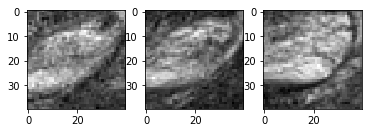

In [161]:
plot_sample_from_MRI_modality(0,prepare_t2_sag_data_labels)

(4800,)
(3, 40, 40)


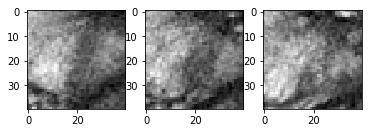

In [162]:
plot_sample_from_MRI_modality(0,prepare_t2_tra_data_labels)

(4800,)
(3, 40, 40)


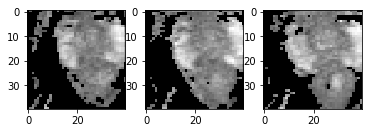

In [163]:
plot_sample_from_MRI_modality(0,prepare_ADC_data_labels)

(4800,)
(3, 40, 40)


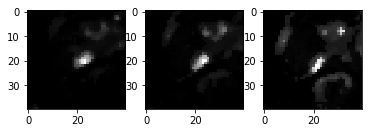

In [164]:
plot_sample_from_MRI_modality(0,prepare_Ktrans_data_labels)

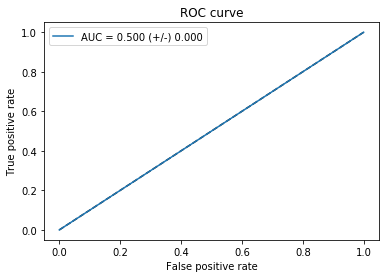

$ADC$ MRI ROC Experiment


In [165]:
plot_ROC_Curve(model, prepare_ADC_data_labels)
print("$ADC$ MRI ROC Experiment")

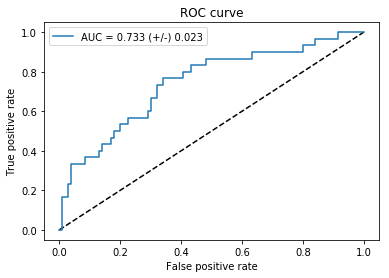

$K^{Trans}$ MRI ROC Experiment


In [166]:
plot_ROC_Curve(model, prepare_Ktrans_data_labels)
print("$K^{Trans}$ MRI ROC Experiment")

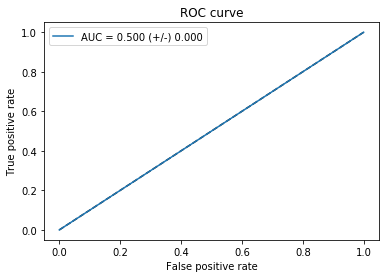

$T2_Sag$ MRI ROC Experiment


In [167]:

plot_ROC_Curve(model, prepare_t2_sag_data_labels)
print("$T2_Sag$ MRI ROC Experiment")

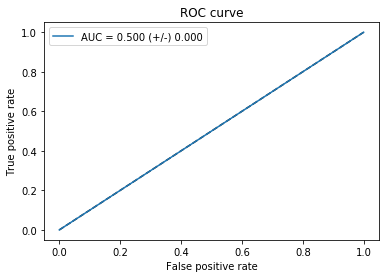

$T2_Tra$ MRI ROC Experiment


In [168]:
plot_ROC_Curve(model, prepare_t2_tra_data_labels)
print("$T2_Tra$ MRI ROC Experiment")

In [178]:
def run_cross_validation(model,prepare_data):
    from sklearn.model_selection import StratifiedKFold

    data_labels = prepare_data()

    kfold = StratifiedKFold(n_splits=8, shuffle=False)
    cvscores = []
    means = []
    stds = []
    i = 0
    for j in range (1,31):
        for train, test in kfold.split(data, labels):
            i += 1
            y_train = to_categorical(labels[train], num_classes=2)
            model.load_weights('model.h5')
            model.fit(data[train], y_train, epochs=30, batch_size=16, shuffle=False,verbose=0)
            # evaluate the model
            y_test = to_categorical(labels[test],num_classes=2)
            scores = model.evaluate(data[test], y_test, verbose=2)
            print("Results for the {} Fold {}: {:.3f}%".format (i, model.metrics_names[1], scores[1]*100))
            cvscores.append(scores[1] * 100)
        clear_output()
        means.append(np.mean(cvscores))
        stds.append(np.std(cvscores))
        print("The results of the {} iteration are the following".format(j))
        i = 1
        print("Acc: {:.3f}% , Std : {:.3f}%".format(np.mean(cvscores), np.std(cvscores)))


    print("The result of the experiment is the following:")
    print("Acc: {:.3f}% , Std : {:.3f}%".format(np.mean(means), np.mean(stds)))
    return np.mean(means), np.mean(stds)




In [179]:
print("Cross validation for ADC")
adc_score, adc_std = run_cross_validation(model, get_all_data_labels_ADC)


The results of the 30 iteration are the following
Acc: 79.087% , Std : 3.352%
The result of the experiment is the following:
Acc: 79.019% , Std : 3.309%


In [180]:
print("Cross validation for Ktrans")
ktrans_score, ktrans_std =run_cross_validation(model, get_all_data_labels_Ktrans)

The results of the 30 iteration are the following
Acc: 79.215% , Std : 3.137%
The result of the experiment is the following:
Acc: 79.136% , Std : 3.035%


In [181]:
print("Cross validation for T2_sag")
t2_sag_score, t2_sag_std =run_cross_validation(model, get_all_data_labels_T2_SAG)

The results of the 30 iteration are the following
Acc: 79.083% , Std : 3.243%
The result of the experiment is the following:
Acc: 79.101% , Std : 3.214%


In [182]:
print("Cross validation for T2_tra")
t2_tra_score, t2_tra_std =run_cross_validation(model, get_all_data_labels_T2_TRA)

The results of the 30 iteration are the following
Acc: 78.622% , Std : 4.786%
The result of the experiment is the following:
Acc: 78.763% , Std : 3.080%


## Pre-Processing modalities

In the following cells We would introduce some code in order to avoid duplicated annotations.

In [0]:
print("This is the $K^{trans} image serie$")
list_of_k_findings = []
dataframe = training_ktrans_imgs_dataframe
print("There is a total of {} rows".format(len(dataframe)))
i = 0
for patient_id in dataframe.ProxID.unique():
    for fid in dataframe[dataframe.ProxID == patient_id].fid.unique():
        list_of_k_findings.append("{} - {}".format(patient_id,fid))
        i = i + 1
print("There are {} findings".format(i))

There is a total of 339 rows
There are 325 findings


In [0]:
print("This is the ADC-DWI image series")
""
list_of_adc_findings = []
dataframe = dyndist_adc_dataframe
print("There is a total of {} rows".format(len(dataframe)))
i = 0
for patient_id in dataframe.ProxID.unique():
    for fid in dataframe[dataframe.ProxID == patient_id].fid.unique():
        list_of_adc_findings.append("{} - {}".format(patient_id,fid))
        i = i + 1
print("There are {} findings".format(i))

There is a total of 345 rows
There are 323 findings


In [0]:
print("This is the T2 Weighted image transversal plane")
list_of_t2_tra_findings = []
dataframe = t2_tse_tra_dataframe
print("There is a total of {} rows".format(len(dataframe)))
i = 0
for patient_id in dataframe.ProxID.unique():
    for fid in dataframe[dataframe.ProxID == patient_id].fid.unique():
        list_of_t2_tra_findings.append("{} - {}".format(patient_id,fid))
        i = i + 1
print("There are {} findings".format(i))

There is a total of 415 rows
There are 325 findings


In [0]:
print("This is the T2 weighted image sagittal plane")
list_of_t2_sag_findings = []
dataframe = t2_tse_sag_dataframe
print("There is a total of {} rows".format(len(dataframe)))
i = 0
for patient_id in dataframe.ProxID.unique():
    for fid in dataframe[dataframe.ProxID == patient_id].fid.unique():
        list_of_t2_sag_findings.append("{} - {}".format(patient_id,fid))
        i = i + 1
print("There are {} findings".format(i))

There is a total of 363 rows
There are 324 findings


In [0]:
list_of_elements_tobe_deleted = []
for finding in list_of_k_findings:
    if (finding not in  list_of_adc_findings):
        if (finding not in list_of_elements_tobe_deleted):
            list_of_elements_tobe_deleted.append(finding)
            
for finding in list_of_k_findings:
    if (finding not in  list_of_t2_sag_findings):
        if (finding not in list_of_elements_tobe_deleted):
            list_of_elements_tobe_deleted.append(finding)
            
for finding in list_of_k_findings:
    if (finding not in  list_of_t2_tra_findings):
        if (finding not in list_of_elements_tobe_deleted):
            list_of_elements_tobe_deleted.append(finding)

In [0]:
list_of_elements_tobe_deleted

['ProstateX-0080 - 1',
 'ProstateX-0140 - 2',
 'ProstateX-0013 - 1',
 'ProstateX-0130 - 1',
 'ProstateX-0172 - 1']

In [0]:
dataframe = training_ktrans_imgs_dataframe
index_to_delete = []
for finding in list_of_elements_tobe_deleted:
    ProxID,fid = finding.split(" - ")
    dataframe2 = dataframe[(dataframe.ProxID == ProxID) & (dataframe.fid == int(fid)) ]
    if (len(dataframe2) != 0):
        index = dataframe2.index[0]
        index_to_delete.append(index)
        print(index)
        dataframe.at[index,"State"] = True

119
223
21
200
282


In [0]:
training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe.drop(index_to_delete)
training_ktrans_imgs_dataframe.reset_index(drop=True)
training_ktrans_imgs_dataframe.index = pd.RangeIndex(len(training_ktrans_imgs_dataframe))

In [0]:
training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.State == True][["ProxID","fid","State"]]

,ProxID,fid,State


In [0]:
dataframe = dyndist_adc_dataframe
index_to_delete = []
for finding in list_of_elements_tobe_deleted:
    ProxID,fid = finding.split(" - ")
    dataframe2 = dataframe[(dataframe.ProxID == ProxID) & (dataframe.fid == int(fid)) ]
    if (len(dataframe2) != 0):
        index = dataframe2.index[0]
        print(index)
        index_to_delete.append(index)
        dataframe.at[index,"State"] = True

21
201
282


In [0]:
dyndist_adc_dataframe = dyndist_adc_dataframe.drop(index_to_delete)
dyndist_adc_dataframe.reset_index(drop=True)
dyndist_adc_dataframe.index = pd.RangeIndex(len(dyndist_adc_dataframe))
dyndist_adc_dataframe[dyndist_adc_dataframe.State == True][["ProxID","fid","State"]]

,ProxID,fid,State


In [0]:
dataframe = t2_tse_sag_dataframe
index_to_delete = []
for finding in list_of_elements_tobe_deleted:
    ProxID,fid = finding.split(" - ")
    dataframe2 = dataframe[(dataframe.ProxID == ProxID) & (dataframe.fid == int(fid)) ]
    if (len(dataframe2) != 0):
        index = dataframe2.index[0]
        index_to_delete.append(index)
        print(index)
        dataframe.at[index,"State"] = True

128
239


In [0]:
t2_tse_sag_dataframe = t2_tse_sag_dataframe.drop(index_to_delete)
t2_tse_sag_dataframe.reset_index(drop=True)
t2_tse_sag_dataframe.index = pd.RangeIndex(len(t2_tse_sag_dataframe))
t2_tse_sag_dataframe[t2_tse_sag_dataframe.State == True][["ProxID","fid","State"]]

,ProxID,fid,State


In [0]:
dataframe = t2_tse_tra_dataframe
index_to_delete = []
for finding in list_of_elements_tobe_deleted:
    ProxID,fid = finding.split(" - ")
    dataframe2 = dataframe[(dataframe.ProxID == ProxID) & (dataframe.fid == int(fid)) ]
    if (len(dataframe2) != 0):
        index = dataframe2.index[0]
        print(index)
        index_to_delete.append(index)
        dataframe.at[index,"State"] = True

136
263
24
239
343


In [0]:
t2_tse_tra_dataframe = t2_tse_tra_dataframe.drop(index_to_delete)
t2_tse_tra_dataframe.reset_index(drop=True)
t2_tse_tra_dataframe.index = pd.RangeIndex(len(t2_tse_tra_dataframe))
t2_tse_tra_dataframe[t2_tse_tra_dataframe.State == True][["ProxID","fid","State"]]

,ProxID,fid,State


In [0]:
print(len(training_ktrans_imgs_dataframe))
print(len(t2_tse_sag_dataframe))
print(len(t2_tse_tra_dataframe))
print(len(dyndist_adc_dataframe))

334
361
410
342


In [0]:
dyndist_adc_dataframe.to_pickle("pickle/dyndist_adc_dataframe.pickle")
training_ktrans_imgs_dataframe.to_pickle("pickle/ktrans_dataframe.pickle")
t2_tse_sag_dataframe.to_pickle("pickle/t2_tse_sag_dataframe.pickle")



In [0]:
t2_tse_tra_dataframe.to_pickle("pickle/t2_tse_tra_dataframe.pickle")